In [1]:
from src.config import Config
config = Config()

### Generate Training Data and Visualize

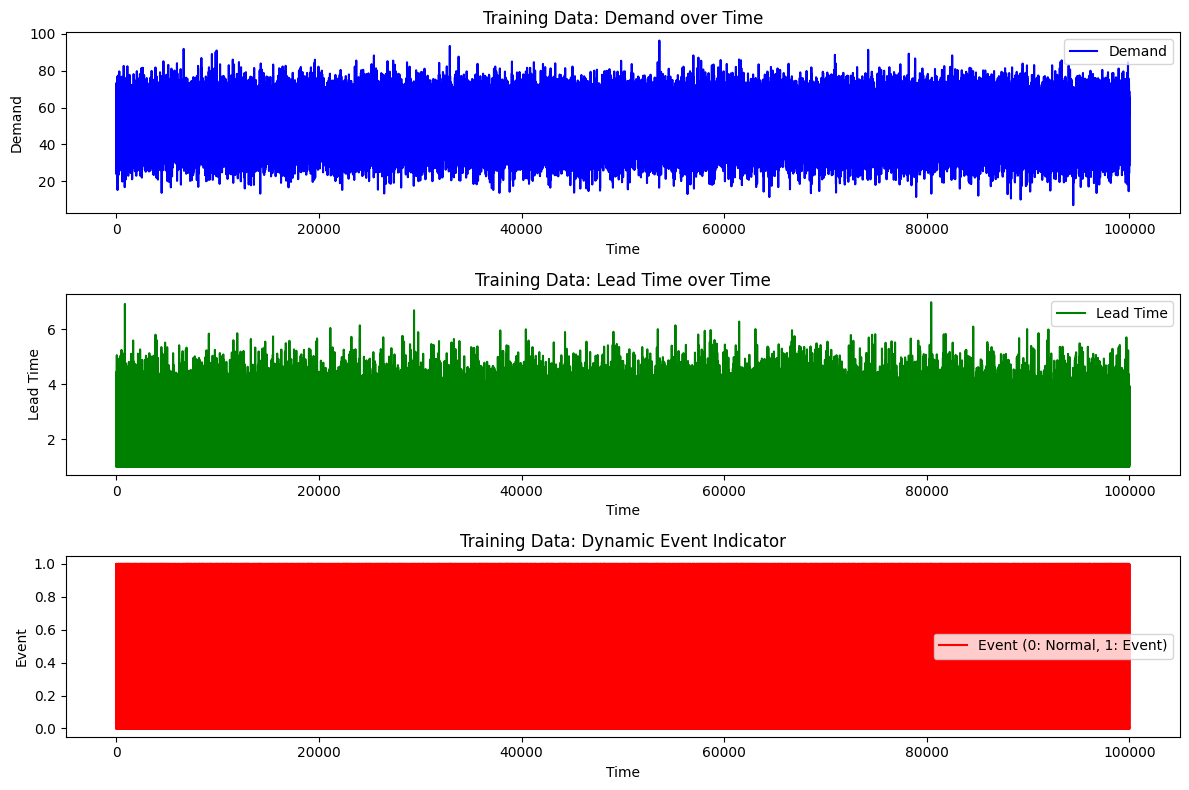

In [2]:
import matplotlib.pyplot as plt 
from src.data.train_data_simulator import generate_offline_data

train_data = generate_offline_data(n_periods=config.training_period, seed=42)
plt.figure(figsize=(12, 8))

# Plot Demand
plt.subplot(3, 1, 1)
plt.plot(train_data['time'], train_data['demand'], label='Demand', color='blue')
plt.title('Training Data: Demand over Time')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()

# Plot Lead Time
plt.subplot(3, 1, 2)
plt.plot(train_data['time'], train_data['lead_time'], label='Lead Time', color='green')
plt.title('Training Data: Lead Time over Time')
plt.xlabel('Time')
plt.ylabel('Lead Time')
plt.legend()

# Plot Dynamic Events
plt.subplot(3, 1, 3)
plt.plot(train_data['time'], train_data['event'], label='Event (0: Normal, 1: Event)', color='red')
plt.title('Training Data: Dynamic Event Indicator')
plt.xlabel('Time')
plt.ylabel('Event')
plt.legend()

plt.tight_layout()
plt.show()

### Train the RL agent using PPO

In [3]:
from src.inventory_env import InventoryEnv
from stable_baselines3 import PPO

env_train = InventoryEnv(offline_data=train_data)
rl_model = PPO('MlpPolicy', env_train, verbose=0, tensorboard_log=config.training_log_dir)
rl_model.learn(total_timesteps=config.n_steps, progress_bar=True)
rl_model.save(config.model_path)

/Users/chu/miniconda3/envs/OGRL/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Output()

### Generate Test Data and Visualize

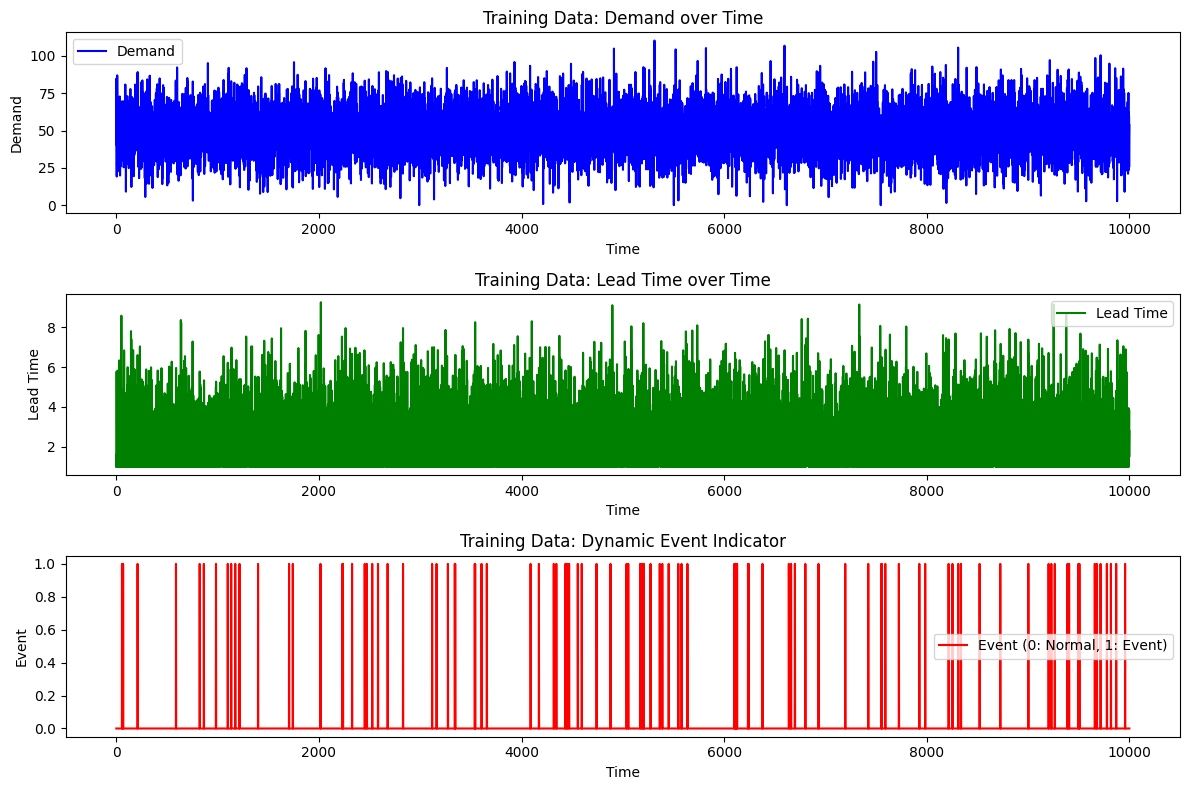

In [4]:
from src.data.test_data_simulator import generate_test_data

# Generate test data and evaluate performance
test_data = generate_test_data(n_periods=config.test_period, seed=24)

plt.figure(figsize=(12, 8))

# Plot Demand
plt.subplot(3, 1, 1)
plt.plot(test_data['time'], test_data['demand'], label='Demand', color='blue')
plt.title('Training Data: Demand over Time')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()

# Plot Lead Time
plt.subplot(3, 1, 2)
plt.plot(test_data['time'], test_data['lead_time'], label='Lead Time', color='green')
plt.title('Training Data: Lead Time over Time')
plt.xlabel('Time')
plt.ylabel('Lead Time')
plt.legend()

# Plot Dynamic Events
plt.subplot(3, 1, 3)
plt.plot(test_data['time'], test_data['event'], label='Event (0: Normal, 1: Event)', color='red')
plt.title('Training Data: Dynamic Event Indicator')
plt.xlabel('Time')
plt.ylabel('Event')
plt.legend()

plt.tight_layout()
plt.show()

### Load the trained RL model and Compare Performances with Pure RL and Pure RO

In [5]:
from src.performance_evaluation import PerformanceEvaluator
from src.robust_optimization import robust_order_quantity

# Load the trained RL model
rl_model = PPO.load(config.model_path, env=env_train)


evaluator = PerformanceEvaluator(
    test_data=test_data,
    env_class=InventoryEnv,
    robust_optimizer=robust_order_quantity,
    rl_model=rl_model,
)

performance_table = evaluator.evaluate_all_methods()
print("\nPerformance Evaluation:")
print(performance_table)

/Users/chu/miniconda3/envs/OGRL/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-25

Performance Evaluation:
              Total Cost  Average Cost per Period  Stockout Frequency  \
vanilla_rl  5.334900e+05                53.354340              3650.0   
pure_ro     1.032079e+06               103.218235              1605.0   
RLeRO       5.353140e+05                53.536758              3650.0   

            Average Inventory Level  Inventory Turnover  \
vanilla_rl                11.080263        45031.375000   
pure_ro                   36.353687        13725.140625   
RLeRO                     11.141068        44785.601562   

            Average Cost during Event Periods  Robust Decisions Triggered  
vanilla_rl                          68.860573                         0.0  
pure_ro                            124.596287                         0.0  
RLeRO                               68.860573                        28.0  
